In [3]:
# All imports
import pandas as pd
import numpy as np
import ast
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

# Load data
dataVer = "review-Vermont.json.gz"
dataMeta = "meta-Vermont.json.gz"

df_meta = pd.read_json(dataMeta, lines=True, compression="gzip")
df_ver = pd.read_json(dataVer, lines=True, compression="gzip")


In [17]:
# Merge review and metadata dataframes
df = df_ver.merge(df_meta, on="gmap_id", how="left")

# Remove rows with missing text
print("Before removing missing text:", len(df))
df = df.dropna(subset=["text"])
print("After removing missing text:", len(df))

# Remove duplicate reviews (same user reviewing same business)
print("Before removing duplicates:", len(df))
df = df.drop_duplicates(subset=['user_id', 'gmap_id'])
print("After removing duplicates:", len(df))

# Remove unnecessary columns
useless = ["name_x", "name_y", "time", "pics", "resp", "address",
           "relative_results", "state", "url", "latitude", "longitude", "MISC"]
maybe = ["description"] # num_of_reviews
df = df.drop(columns=useless + maybe)

# Remove rows with missing ratings
df = df.dropna(subset=['rating'])
print("After removing missing ratings:", len(df))

# Save preprocessed data
df.to_csv("merged.csv", index=False)
print("Preprocessed data saved to merged.csv")

Before removing missing text: 324981
After removing missing text: 178326
Before removing duplicates: 178326
After removing duplicates: 174998
After removing missing ratings: 174998
Preprocessed data saved to merged.csv


In [18]:
# Display sample of preprocessed data
df.head()

,user_id,rating,text,gmap_id,category,avg_rating,num_of_reviews,price,hours
0,1.180269e+20,5,Always done right from wood stove to screens!,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,148,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu..."
2,1.015327e+20,5,A great company to work with. Their sales and...,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,148,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu..."
4,1.154041e+20,5,Great place to do business with staff was grea...,0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,148,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu..."
6,1.047893e+20,5,"Awesome Customer service, quick response, and ...",0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,148,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu..."
8,1.089807e+20,5,"If you need a top quality job, by a group of p...",0x89e02445cb9db457:0x37f42bff4edf7a43,"[Security system supplier, Fire protection equ...",4.9,148,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu..."


# II. Data Exploration and Visualization

This section provides visualizations and statistical analysis of the dataset to understand the data distribution and relationships between features.


In [19]:
# Load preprocessed data for visualization
df_viz = pd.read_csv("merged.csv")

# Basic statistics
print("Dataset Statistics:")
print(f"Total reviews: {len(df_viz):,}")
print(f"Unique users: {df_viz['user_id'].nunique():,}")
print(f"Unique businesses: {df_viz['gmap_id'].nunique():,}")
print(f"\nRating Statistics:")
print(df_viz['rating'].describe())

# Calculate text length
df_viz['text_length'] = df_viz['text'].astype(str).apply(len)
print(f"\nText Length Statistics:")
print(df_viz['text_length'].describe())


Dataset Statistics:
Total reviews: 174,998
Unique users: 12,655
Unique businesses: 5,040

Rating Statistics:
count    174998.000000
mean          4.329941
std           1.044621
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

Text Length Statistics:
count    174998.000000
mean        112.752849
std         164.424598
min           1.000000
25%          31.000000
50%          61.000000
75%         130.000000
max        4092.000000
Name: text_length, dtype: float64


## A. Rating Distribution


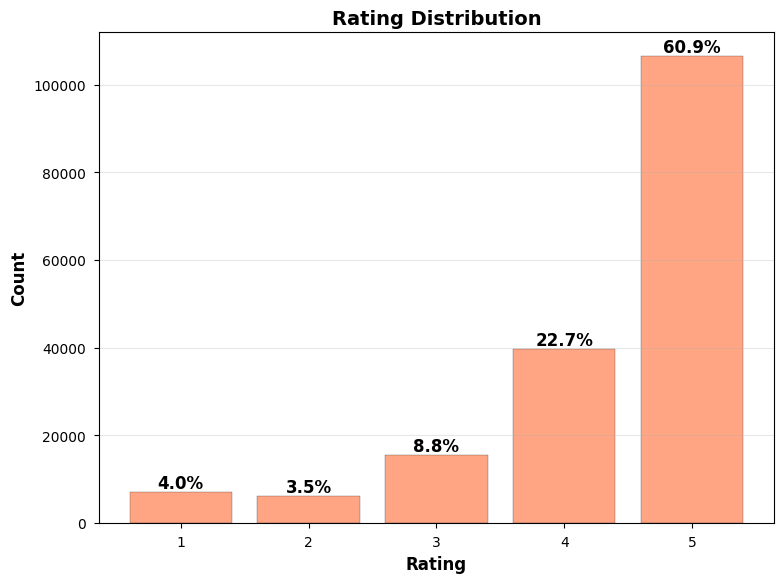


Rating Distribution:
  Rating 1: 7,044 (4.0%)
  Rating 2: 6,130 (3.5%)
  Rating 3: 15,483 (8.8%)
  Rating 4: 39,727 (22.7%)
  Rating 5: 106,614 (60.9%)


In [20]:
# Rating distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Bar plot with percentages
rating_counts = df_viz['rating'].value_counts().sort_index()
rating_pct = (rating_counts / len(df_viz) * 100).round(1)
bars = ax.bar(rating_counts.index, rating_counts.values, edgecolor='black', alpha=0.7, color='coral')
ax.set_xlabel('Rating', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Rating Distribution', fontweight='bold')
ax.set_xticks([1, 2, 3, 4, 5])
ax.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for idx, val in zip(rating_counts.index, rating_counts.values):
    ax.text(idx, val, f'{rating_pct[idx]:.1f}%',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nRating Distribution:")
for rating in sorted(rating_counts.index):
    print(f"  Rating {int(rating)}: {rating_counts[rating]:,} ({rating_pct[rating]:.1f}%)")


## B. Text Length Analysis


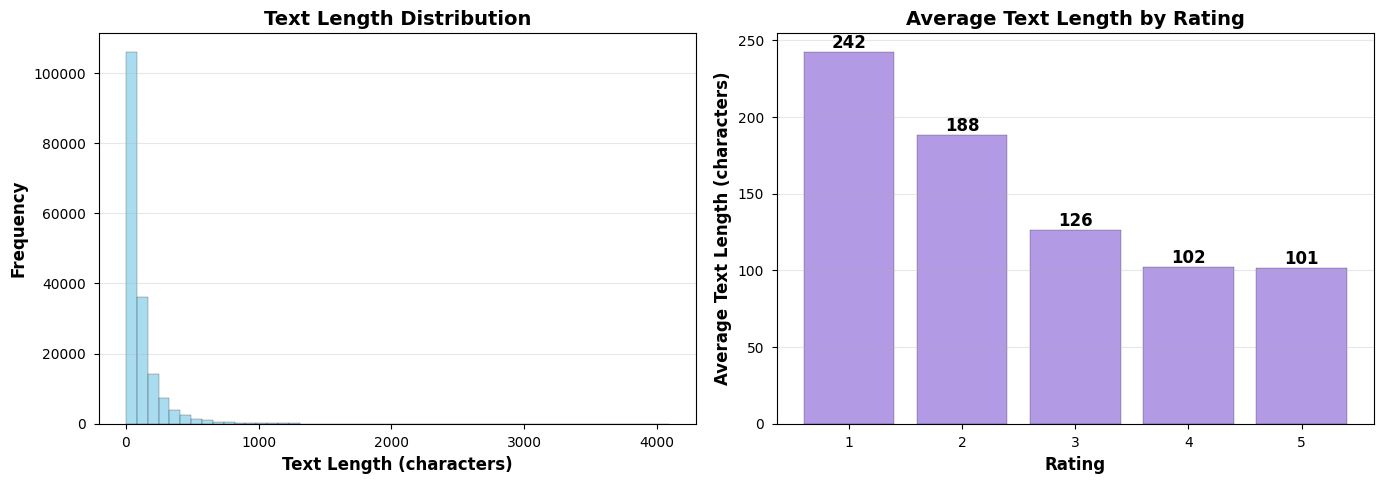


Average Text Length by Rating:
  Rating 1: 242.5 characters
  Rating 2: 188.3 characters
  Rating 3: 126.4 characters
  Rating 4: 102.5 characters
  Rating 5: 101.7 characters


In [21]:
# Text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_viz['text_length'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Text Length (characters)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Text Length Distribution', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Rating vs Text Length
rating_text_length = df_viz.groupby('rating')['text_length'].mean()
bars = axes[1].bar(rating_text_length.index, rating_text_length.values,
                   edgecolor='black', alpha=0.7, color='mediumpurple')
axes[1].set_xlabel('Rating', fontweight='bold')
axes[1].set_ylabel('Average Text Length (characters)', fontweight='bold')
axes[1].set_title('Average Text Length by Rating', fontweight='bold')
axes[1].set_xticks([1, 2, 3, 4, 5])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for idx, val in zip(rating_text_length.index, rating_text_length.values):
    axes[1].text(idx, val, f'{int(val)}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage Text Length by Rating:")
for rating in sorted(rating_text_length.index):
    print(f"  Rating {int(rating)}: {rating_text_length[rating]:.1f} characters")


## C. Correlation Analysis


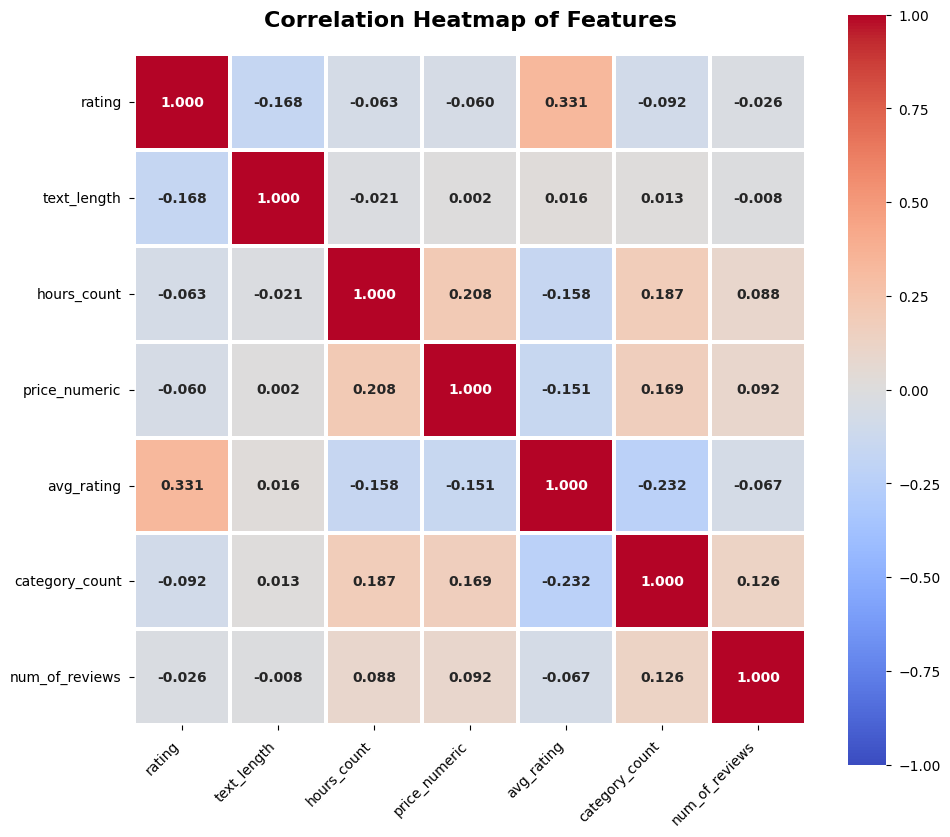


Correlation Matrix:
                rating  text_length  hours_count  price_numeric  avg_rating  \
rating           1.000       -0.168       -0.063         -0.060       0.331   
text_length     -0.168        1.000       -0.021          0.002       0.016   
hours_count     -0.063       -0.021        1.000          0.208      -0.158   
price_numeric   -0.060        0.002        0.208          1.000      -0.151   
avg_rating       0.331        0.016       -0.158         -0.151       1.000   
category_count  -0.092        0.013        0.187          0.169      -0.232   
num_of_reviews  -0.026       -0.008        0.088          0.092      -0.067   

                category_count  num_of_reviews  
rating                  -0.092          -0.026  
text_length              0.013          -0.008  
hours_count              0.187           0.088  
price_numeric            0.169           0.092  
avg_rating              -0.232          -0.067  
category_count           1.000           0.126  
num

In [35]:
# ============================================================================
# Feature Engineering for Correlation Analysis
# ============================================================================
df_corr = df_viz.copy()

# --- Feature 1: Text Length ---
df_corr['text_length'] = df_corr['text'].astype(str).str.len()

# --- Feature 2: Hours Count (number of open days per week) ---
def count_open_days(hours_str):
    """Count the number of days a business is open per week.

    Args:
        hours_str: String like "[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], ...]"
                   or already parsed list

    Returns:
        Number of days the business is open (0-7)
    """
    if pd.isna(hours_str):
        return 0

    # Parse hours string to list if it's a string
    try:
        if isinstance(hours_str, str):
            # Try to parse as Python literal (list of lists)
            hours_list = ast.literal_eval(hours_str)
        else:
            # Already a list
            hours_list = hours_str

        # Validate that we got a list
        if not isinstance(hours_list, list):
            return 0

        # Count days that are not 'Closed'
        # Format: [[DayName, Hours], [DayName, Hours], ...]
        # Example: [[Thursday, 8AM–5PM], [Friday, 8AM–5PM], ...]
        open_count = 0
        for day_info in hours_list:
            # day_info should be a list like [DayName, Hours]
            if isinstance(day_info, list) and len(day_info) >= 2:
                # Check if the hours part (index 1) is not 'Closed'
                hours_value = day_info[1]
                if hours_value != 'Closed' and hours_value is not None:
                    open_count += 1

        return open_count
    except (ValueError, SyntaxError, TypeError) as e:
        # If parsing fails, return 0
        return 0

df_corr['hours_count'] = df_corr['hours'].apply(count_open_days)

# --- Feature 3: Price (converted to numerical) ---
if 'price' in df_corr.columns:
    price_map = {None: 0, np.nan: 0, '$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
    df_corr['price_numeric'] = df_corr['price'].map(price_map).fillna(0)
else:
    df_corr['price_numeric'] = 0

# --- Feature 4: Average Rating (excluding current review) ---
# Calculate avg_rating excluding current review to avoid data leakage
business_stats = df_corr.groupby('gmap_id')['rating'].agg(['sum', 'count']).reset_index()
business_stats.columns = ['gmap_id', 'total_rating', 'count']

df_corr = df_corr.merge(business_stats, on='gmap_id', how='left')
df_corr['avg_rating'] = (df_corr['total_rating'] - df_corr['rating']) / (df_corr['count'] - 1)
# Handle businesses with only one review
# Not needed in 10 core
# df_corr.loc[df_corr['count'] == 1, 'avg_rating'] = df_corr.loc[df_corr['count'] == 1, 'rating']
# df_corr = df_corr.drop(columns=['total_rating', 'count'])

# --- Feature 5: Category Count (number of categories per business) ---
def count_categories(cat_str):
    """Count the number of categories for a business."""
    if pd.isna(cat_str):
        return 0
    try:
        if isinstance(cat_str, str):
            cat_list = ast.literal_eval(cat_str)
        else:
            cat_list = cat_str
        return len(cat_list) if isinstance(cat_list, list) else 0
    except:
        return 0

if 'category' in df_corr.columns:
    df_corr['category_count'] = df_corr['category'].apply(count_categories)
else:
    df_corr['category_count'] = 0

# --- Feature 6: Number of Reviews ---
if 'num_of_reviews' in df_corr.columns:
    df_corr['num_of_reviews'] = pd.to_numeric(df_corr['num_of_reviews'], errors='raise')


# ============================================================================
# Correlation Analysis
# ============================================================================
# Select numerical features for correlation analysis
corr_features = ['rating', 'text_length', 'hours_count', 'price_numeric',
                 'avg_rating', 'category_count', 'num_of_reviews']
df_corr_subset = df_corr[corr_features].dropna()

# Calculate correlation matrix
corr_matrix = df_corr_subset.corr()

# ============================================================================
# Visualization
# ============================================================================
n_features = len(corr_matrix)
fig_size = max(10, n_features * 1.2)

plt.figure(figsize=(fig_size, fig_size))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1.5,
    cbar_kws={"shrink": 0.8},
    vmin=-1,
    vmax=1,
    annot_kws={
        'fontsize': max(10, int(14 - n_features * 0.5)),
        'fontweight': 'bold'
    },
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)
plt.title('Correlation Heatmap of Features', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Results Summary
# ============================================================================
print(f"\n{'='*60}")
print("Correlation Matrix:")
print(f"{'='*60}")
print(corr_matrix.round(3))

# Key correlations with rating
print(f"\n{'='*60}")
print("Correlation with Rating (Target Variable):")
print(f"{'='*60}")
rating_corrs = corr_matrix['rating'].sort_values(ascending=False)
for feature, corr_value in rating_corrs.items():
    if feature != 'rating':
        print(f"  {feature:15s}: {corr_value:6.3f}")
print(f"{'='*60}")


# III. Modeling

This section describes the models we implement for rating prediction. We start with simple baselines and progressively build more sophisticated models that incorporate text features and metadata.


## A. Baseline Models

We implement three baseline models to establish a performance floor:

1. **Global Mean**: Predicts the average rating across all training examples
2. **User Means**: Predicts the user's average rating across all training examples.
3. **Item Means**: Predicts the item's average rating across all training examples.

In [48]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['user_id', 'rating', 'gmap_id'])
df = df.dropna(subset=['user_id', 'rating', 'gmap_id'])
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Test Split (80/20)
# ============================================================================
train, test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['rating']
)

print(f"\nData Split:")
print(f"  Train: {len(train):,} samples ({len(train)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test):,} samples ({len(test)/len(df)*100:.1f}%)")

# ============================================================================
# Baseline 1: Global Mean
# ============================================================================
# Predict the average rating across all training examples
global_mean = train['rating'].mean()
preds_global = [global_mean] * len(test)
mse_global = mean_squared_error(test['rating'], preds_global)

print(f"\n{'='*60}")
print("Baseline 1: Global Mean")
print(f"{'='*60}")
print(f"Prediction: {global_mean:.4f} (constant)")
print(f"Test MSE:   {mse_global:.4f}")
print(f"{'='*60}")


# ============================================================================
# Baseline 2: User Means
# ============================================================================
# Predict the average rating the user gives across all training examples
# If the user isn't found in the training data, use the global average instead
user_means = train.groupby('user_id')['rating'].mean()
preds_user = test['user_id'].map(user_means)
preds_user = preds_user.fillna(global_mean)
mse_user = mean_squared_error(test['rating'], preds_user)

print(f"\n{'='*60}")
print("Baseline 2: User Means")
print(f"{'='*60}")
print(f"Test MSE:   {mse_user:.4f}")
print(f"{'='*60}")


# ============================================================================
# Baseline 3: Item Means
# ============================================================================
# Predict the average rating of the item
# If the item isn't found in the training data, use the global average instead
item_means = train.groupby('gmap_id')['rating'].mean()
preds_item = test['gmap_id'].map(item_means)
preds_item = preds_item.fillna(global_mean)

mse_item = mean_squared_error(test['rating'], preds_item)

print(f"\n{'='*60}")
print("Baseline 3: Item Means")
print(f"{'='*60}")
print(f"Test MSE:   {mse_item:.4f}")
print(f"{'='*60}")


Data Split:
  Train: 139,998 samples (80.0%)
  Test:  35,000 samples (20.0%)

Baseline 1: Global Mean
Prediction: 4.3299 (constant)
Test MSE:   1.0913

Baseline 2: User Means
Test MSE:   0.9750

Baseline 3: Item Means
Test MSE:   0.9822


## B. Text-based Linear Model (Main Model #1)

**Intuition**: The sentiment and expressions in text are most directly connected to ratings. Words, phrases, and sentiment expressions contained in review text provide key information for predicting the ratings assigned by users.

We use:
- **TF-IDF vectorization** to convert text into numerical features
- **Ridge Regression** for regularization and to handle the high-dimensional feature space


In [12]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['text', 'rating'])
df = df.dropna(subset=['text', 'rating'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Validation/Test Split (70/15/15)
# ============================================================================
# Step 1: Separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    df['text'], df['rating'],
    test_size=0.15,
    random_state=42,
    stratify=df['rating']
)

# Step 2: Split remaining 85% into train (70%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.15/0.85,  # ~17.6% of 85% = 15% of total
    random_state=42,
    stratify=y_temp
)

print(f"\nData Split:")
print(f"  Train:      {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")

# ============================================================================
# Feature Engineering: TF-IDF Vectorization
# ============================================================================
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),    # Unigrams and bigrams
    min_df=2,              # Ignore terms in < 2 documents
    max_df=0.95            # Ignore terms in > 95% of documents
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"\nTF-IDF Features:")
print(f"  Shape: {X_train_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf.vocabulary_):,}")

# ============================================================================
# Hyperparameter Tuning on Validation Set
# ============================================================================
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
best_alpha = 1.0
best_val_mse = float('inf')

print(f"\n{'='*60}")
print("Hyperparameter Tuning (Validation Set)")
print(f"{'='*60}")
for alpha in alpha_values:
    model_temp = Ridge(alpha=alpha)
    model_temp.fit(X_train_tfidf, y_train)
    y_pred_val = model_temp.predict(X_val_tfidf)
    val_mse = mean_squared_error(y_val, y_pred_val)
    print(f"  Alpha = {alpha:4.1f}:  Validation MSE = {val_mse:.4f}")
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_alpha = alpha

print(f"\nBest hyperparameters:")
print(f"  Alpha = {best_alpha:.1f}")
print(f"  Validation MSE = {best_val_mse:.4f}")

# ============================================================================
# Final Model Training and Evaluation
# ============================================================================
# Train on full training set with best hyperparameters
model_text = Ridge(alpha=best_alpha)
model_text.fit(X_train_tfidf, y_train)

# Evaluate on test set (final evaluation only)
y_pred_text = model_text.predict(X_test_tfidf)
mse_text = mean_squared_error(y_test, y_pred_text)

print(f"\n{'='*60}")
print(f"Final Model Performance (Test Set)")
print(f"{'='*60}")
print(f"Model: Text-based (TF-IDF + Ridge)")
print(f"Alpha: {best_alpha:.1f}")
print(f"Test MSE: {mse_text:.4f}")
print(f"{'='*60}")



Data Split:
  Train:      122,498 samples (70.0%)
  Validation: 26,250 samples (15.0%)
  Test:       26,250 samples (15.0%)

TF-IDF Features:
  Shape: (122498, 50000)
  Vocabulary size: 50,000

Hyperparameter Tuning (Validation Set)
  Alpha =  0.1:  Validation MSE = 0.6029
  Alpha =  0.5:  Validation MSE = 0.5091
  Alpha =  1.0:  Validation MSE = 0.4902
  Alpha =  2.0:  Validation MSE = 0.4851
  Alpha =  5.0:  Validation MSE = 0.4989
  Alpha = 10.0:  Validation MSE = 0.5244

Best hyperparameters:
  Alpha = 2.0
  Validation MSE = 0.4851

Final Model Performance (Test Set)
Model: Text-based (TF-IDF + Ridge)
Alpha: 2.0
Test MSE: 0.4940


## C. Text + Metadata Model

This model combines text features with metadata to capture both semantic content and contextual information about the business.

**Features**:
- **TF-IDF(text)**: Text vectorization
- **avg_rating**: Average rating of the business (excluding current review) - high correlation feature
- **text_length**: Length of review text - correlation feature

We use **Ridge Regression** for this model.


In [37]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['text', 'rating', 'gmap_id'])
df = df.dropna(subset=['text', 'rating', 'gmap_id'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Validation/Test Split (70/15/15)
# ============================================================================
# Step 1: Separate test set (15%)
df_temp, df_test = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df['rating']
)

# Step 2: Split remaining 85% into train (70%) and validation (15%)
df_train, df_val = train_test_split(
    df_temp,
    test_size=0.15/0.85,  # ~17.6% of 85% = 15% of total
    random_state=42,
    stratify=df_temp['rating']
)

print(f"\nData Split:")
print(f"  Train:      {len(df_train):,} samples ({len(df_train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(df_val):,} samples ({len(df_val)/len(df)*100:.1f}%)")
print(f"  Test:       {len(df_test):,} samples ({len(df_test)/len(df)*100:.1f}%)")

# ============================================================================
# Feature Engineering
# ============================================================================

# --- Feature 1: TF-IDF Vectorization ---
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf.fit_transform(df_train['text'])
X_val_tfidf = tfidf.transform(df_val['text'])
X_test_tfidf = tfidf.transform(df_test['text'])

print(f"\nTF-IDF Features:")
print(f"  Shape: {X_train_tfidf.shape}")

# --- Feature 2: Average Rating (excluding current review) ---
# Calculate business statistics from train set only (avoid data leakage)
business_stats = df_train.groupby('gmap_id')['rating'].agg(['sum', 'count']).reset_index()
business_stats.columns = ['gmap_id', 'total_rating', 'count']

# Train set: exclude current review
df_train_merged = df_train.merge(business_stats, on='gmap_id', how='left')
df_train_merged['avg_rating'] = (df_train_merged['total_rating'] - df_train_merged['rating']) / (df_train_merged['count'] - 1)
df_train_merged.loc[df_train_merged['count'] == 1, 'avg_rating'] = df_train_merged.loc[df_train_merged['count'] == 1, 'rating']
avg_rating_train = df_train_merged['avg_rating'].fillna(df_train['rating'].mean()).values

# Validation/Test sets: use train statistics only
df_val_merged = df_val.merge(business_stats, on='gmap_id', how='left')
df_val_merged['avg_rating'] = df_val_merged['total_rating'] / df_val_merged['count']
avg_rating_val = df_val_merged['avg_rating'].fillna(df_train['rating'].mean()).values

df_test_merged = df_test.merge(business_stats, on='gmap_id', how='left')
df_test_merged['avg_rating'] = df_test_merged['total_rating'] / df_test_merged['count']
avg_rating_test = df_test_merged['avg_rating'].fillna(df_train['rating'].mean()).values

# --- Feature 3: Text Length ---
text_length_train = df_train['text'].str.len().values
text_length_val = df_val['text'].str.len().values
text_length_test = df_test['text'].str.len().values

print(f"\nMetadata Features:")
print(f"  Avg Rating - Train: {np.mean(avg_rating_train):.2f}, Val: {np.mean(avg_rating_val):.2f}, Test: {np.mean(avg_rating_test):.2f}")
print(f"  Text Length - Train: {np.mean(text_length_train):.1f}, Val: {np.mean(text_length_val):.1f}, Test: {np.mean(text_length_test):.1f}")

# --- Combine and Scale Features ---
metadata_train = np.column_stack([avg_rating_train, text_length_train])
metadata_val = np.column_stack([avg_rating_val, text_length_val])
metadata_test = np.column_stack([avg_rating_test, text_length_test])

# Scale metadata features (fit only on train to avoid data leakage)
scaler = StandardScaler()
metadata_train_scaled = scaler.fit_transform(metadata_train)
metadata_val_scaled = scaler.transform(metadata_val)
metadata_test_scaled = scaler.transform(metadata_test)

# Combine TF-IDF (sparse) + metadata (dense)
X_train_combined = hstack([X_train_tfidf, metadata_train_scaled])
X_val_combined = hstack([X_val_tfidf, metadata_val_scaled])
X_test_combined = hstack([X_test_tfidf, metadata_test_scaled])

print(f"\nCombined Features:")
print(f"  Train: {X_train_combined.shape}")
print(f"  Val:   {X_val_combined.shape}")
print(f"  Test:  {X_test_combined.shape}")

# ============================================================================
# Hyperparameter Tuning on Validation Set
# ============================================================================
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
best_alpha = 1.0
best_val_mse = float('inf')

print(f"\n{'='*60}")
print("Hyperparameter Tuning (Validation Set)")
print(f"{'='*60}")
for alpha in alpha_values:
    model_temp = Ridge(alpha=alpha)
    model_temp.fit(X_train_combined, df_train['rating'])
    y_pred_val = model_temp.predict(X_val_combined)
    val_mse = mean_squared_error(df_val['rating'], y_pred_val)
    print(f"  Alpha = {alpha:4.1f}:  Validation MSE = {val_mse:.4f}")
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_alpha = alpha

print(f"\nBest hyperparameters:")
print(f"  Alpha = {best_alpha:.1f}")
print(f"  Validation MSE = {best_val_mse:.4f}")

# ============================================================================
# Final Model Training and Evaluation
# ============================================================================
# Train on full training set with best hyperparameters
model_ridge = Ridge(alpha=best_alpha)
model_ridge.fit(X_train_combined, df_train['rating'])

# Evaluate on test set (final evaluation only)
y_pred_ridge = model_ridge.predict(X_test_combined)
mse_ridge = mean_squared_error(df_test['rating'], y_pred_ridge)

print(f"\n{'='*60}")
print(f"Final Model Performance (Test Set)")
print(f"{'='*60}")
print(f"Model: Text + Metadata (TF-IDF + avg_rating + text_length + Ridge)")
print(f"Alpha: {best_alpha:.1f}")
print(f"Test MSE: {mse_ridge:.4f}")
print(f"{'='*60}")



Data Split:
  Train:      122,498 samples (70.0%)
  Validation: 26,250 samples (15.0%)
  Test:       26,250 samples (15.0%)

TF-IDF Features:
  Shape: (122498, 50000)

Metadata Features:
  Avg Rating - Train: 4.33, Val: 4.33, Test: 4.33
  Text Length - Train: 112.7, Val: 112.6, Test: 112.9

Combined Features:
  Train: (122498, 50002)
  Val:   (26250, 50002)
  Test:  (26250, 50002)

Hyperparameter Tuning (Validation Set)
  Alpha =  0.1:  Validation MSE = 0.5945
  Alpha =  0.5:  Validation MSE = 0.5017
  Alpha =  1.0:  Validation MSE = 0.4828
  Alpha =  2.0:  Validation MSE = 0.4772
  Alpha =  5.0:  Validation MSE = 0.4896
  Alpha = 10.0:  Validation MSE = 0.5130

Best hyperparameters:
  Alpha = 2.0
  Validation MSE = 0.4772

Final Model Performance (Test Set)
Model: Text + Metadata (TF-IDF + avg_rating + text_length + Ridge)
Alpha: 2.0
Test MSE: 0.4852


## D. LinearSVR Model

**Explanation**: Linear Support Vector Regression (LinearSVR) is a linear model that uses support vector machines for regression tasks. It can handle high-dimensional sparse data well and often performs better than Ridge regression for certain types of text classification problems.

We use **LinearSVR** with TF-IDF features for rating prediction.


In [14]:
# ============================================================================
# Data Loading and Preparation
# ============================================================================
df = pd.read_csv("merged.csv", usecols=['text', 'rating'])
df = df.dropna(subset=['text', 'rating'])
df['text'] = df['text'].astype(str)
df['rating'] = df['rating'].astype(float)

# ============================================================================
# Train/Validation/Test Split (70/15/15)
# ============================================================================
# Step 1: Separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    df['text'], df['rating'],
    test_size=0.15,
    random_state=42,
    stratify=df['rating']
)

# Step 2: Split remaining 85% into train (70%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.15/0.85,
    random_state=42,
    stratify=y_temp
)

print(f"\nData Split:")
print(f"  Train:      {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")

# ============================================================================
# Feature Engineering: TF-IDF Vectorization
# ============================================================================
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),    # Unigrams and bigrams
    min_df=2,              # Ignore terms in < 2 documents
    max_df=0.95            # Ignore terms in > 95% of documents
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"\nTF-IDF Features:")
print(f"  Shape: {X_train_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf.vocabulary_):,}")

# ============================================================================
# Hyperparameter Tuning on Validation Set
# ============================================================================
# C: Regularization parameter (inverse of regularization strength)
# epsilon: Epsilon-tube (no penalty within this range)
C_values = [0.1, 0.5, 1.0, 2.0]
epsilon_values = [0.0, 0.1, 0.2]
best_C = 1.0
best_epsilon = 0.0
best_val_mse = float('inf')

print(f"\n{'='*60}")
print("Hyperparameter Tuning (Validation Set)")
print(f"{'='*60}")
for C in C_values:
    for epsilon in epsilon_values:
        model_temp = LinearSVR(C=C, epsilon=epsilon, max_iter=1000, random_state=42)
        model_temp.fit(X_train_tfidf, y_train)
        y_pred_val = model_temp.predict(X_val_tfidf)
        y_pred_val = np.clip(y_pred_val, 1.0, 5.0)  # Clip to valid rating range
        val_mse = mean_squared_error(y_val, y_pred_val)
        print(f"  C = {C:4.1f}, epsilon = {epsilon:.1f}:  Validation MSE = {val_mse:.4f}")
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_C = C
            best_epsilon = epsilon

print(f"\nBest hyperparameters:")
print(f"  C = {best_C:.1f}")
print(f"  epsilon = {best_epsilon:.1f}")
print(f"  Validation MSE = {best_val_mse:.4f}")

# ============================================================================
# Final Model Training and Evaluation
# ============================================================================
# Train on full training set with best hyperparameters
model_svr = LinearSVR(C=best_C, epsilon=best_epsilon, max_iter=1000, random_state=42)
model_svr.fit(X_train_tfidf, y_train)

# Evaluate on test set (final evaluation only)
y_pred_svr = model_svr.predict(X_test_tfidf)
y_pred_svr = np.clip(y_pred_svr, 1.0, 5.0)  # Clip to valid rating range
mse_svr = mean_squared_error(y_test, y_pred_svr)

print(f"\n{'='*60}")
print(f"Final Model Performance (Test Set)")
print(f"{'='*60}")
print(f"Model: LinearSVR (TF-IDF + LinearSVR)")
print(f"C: {best_C:.1f}, epsilon: {best_epsilon:.1f}")
print(f"Test MSE: {mse_svr:.4f}")
print(f"{'='*60}")



Data Split:
  Train:      122,498 samples (70.0%)
  Validation: 26,250 samples (15.0%)
  Test:       26,250 samples (15.0%)

TF-IDF Features:
  Shape: (122498, 50000)
  Vocabulary size: 50,000

Hyperparameter Tuning (Validation Set)
  C =  0.1, epsilon = 0.0:  Validation MSE = 0.6193
  C =  0.1, epsilon = 0.1:  Validation MSE = 0.5884
  C =  0.1, epsilon = 0.2:  Validation MSE = 0.5661
  C =  0.5, epsilon = 0.0:  Validation MSE = 0.5236
  C =  0.5, epsilon = 0.1:  Validation MSE = 0.5069
  C =  0.5, epsilon = 0.2:  Validation MSE = 0.4941
  C =  1.0, epsilon = 0.0:  Validation MSE = 0.5167
  C =  1.0, epsilon = 0.1:  Validation MSE = 0.5036
  C =  1.0, epsilon = 0.2:  Validation MSE = 0.4937
  C =  2.0, epsilon = 0.0:  Validation MSE = 0.5296
  C =  2.0, epsilon = 0.1:  Validation MSE = 0.5178
  C =  2.0, epsilon = 0.2:  Validation MSE = 0.5082

Best hyperparameters:
  C = 1.0
  epsilon = 0.2
  Validation MSE = 0.4937

Final Model Performance (Test Set)
Model: LinearSVR (TF-IDF + Line

## E. Model Comparison

Below is a comprehensive comparison of all models we implemented:


In [49]:
# ============================================================================
# Model Comparison
# ============================================================================
results = {
    'Model': [
        'Global Mean (Baseline)',
        'User Means (Baseline)',
        'Item Means (Baseline)',
        'LinearSVR',
        'Text-based (TF-IDF + Ridge)',
        'Text + Metadata (Ridge)',
    ],
    'MSE': [
        mse_global,
        mse_user,
        mse_item,
        mse_svr,
        mse_text,
        mse_ridge,
    ]
}

comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('MSE')

print(f"\n{'='*80}")
print("MODEL COMPARISON (Sorted by MSE - Lower is Better)")
print(f"{'='*80}")
print(comparison_df.to_string(index=False))
print(f"{'='*80}")

comparison_df



MODEL COMPARISON (Sorted by MSE - Lower is Better)
                      Model      MSE
    Text + Metadata (Ridge) 0.485202
Text-based (TF-IDF + Ridge) 0.494020
                  LinearSVR 0.504477
      User Means (Baseline) 0.974978
      Item Means (Baseline) 0.982198
     Global Mean (Baseline) 1.091299


,Model,MSE
5,Text + Metadata (Ridge),0.485202
4,Text-based (TF-IDF + Ridge),0.494020
3,LinearSVR,0.504477
1,User Means (Baseline),0.974978
2,Item Means (Baseline),0.982198
0,Global Mean (Baseline),1.091299


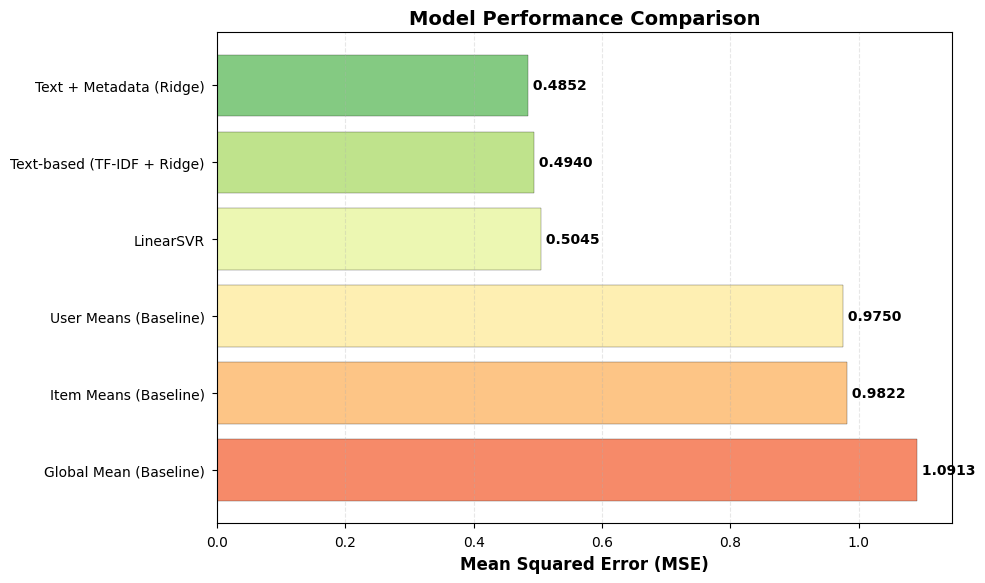

In [50]:
# ============================================================================
# Model Performance Visualization
# ============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Sort by MSE (best to worst)
comparison_sorted = comparison_df.sort_values('MSE')

# Color gradient: green (best) to red (worst)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(comparison_sorted)))
bars = ax.barh(
    comparison_sorted['Model'],
    comparison_sorted['MSE'],
    color=colors,
    edgecolor='black',
    alpha=0.8
)

# Formatting
ax.set_xlabel('Mean Squared Error (MSE)', fontweight='bold', fontsize=12)
ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()  # Best model on top

# Add value labels on bars
for i, (idx, val) in enumerate(zip(comparison_sorted.index, comparison_sorted['MSE'])):
    ax.text(val, i, f' {val:.4f}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
